# This notebook analyzes experiments on MNIST data by visualizing results.

Organize imports, set constants, and load result files.

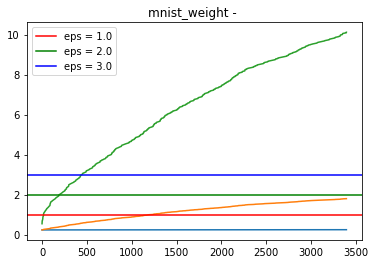

PATE - labels_answered: 503
PATE - accuracy: 0.974
-------
mnist_weight - labels_answered: 444
mnist_weight - labels_answered (0): 3396
mnist_weight - labels_answered (1):  3396
mnist_weight - labels_answered (2): 444
mnist_weight - wGNMax: accuracy: 0.9719999999999999


In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from ast import literal_eval
import os
import yaml
import json

epsilons= [1.,2.,3.]
pate_epsilons = epsilons

experiments = ["weight", "vanish", "mnist_upsample_2", "mnist_upsample_row_2"]

def under_budget(costs, max_epsilons):
    """ returns bool if all costs are under budget"""
    return all([costs[i] < max_epsilons[i] for i in range(len(costs))])


voting_name = 'stats_votings.csv'
teachers_name = "stats_teachers.csv"

yaml_base_path = "$HOME/code/personalized-pate/per-point-pate/experiment_plans/set_5_paper_submission/"
DATA_DIR = "$HOME/datadrive_individualized_pate/"

BASELINE_PATH= f"{DATA_DIR}/pate/"

pate_config_path = os.path.join(yaml_base_path, "mnist_pate.yaml")
df_vb = pd.read_csv(os.path.join(BASELINE_PATH, voting_name))
with open(pate_config_path, 'r') as stream:
    pate_config = yaml.safe_load(stream)
cost_curve_b = json.loads(df_vb["costs_curve"].iloc[0])
labels_answered_b = sum(np.array([under_budget(cost_curve_b[i], pate_epsilons) for i in range(len(cost_curve_b))]))



    
experiment = experiments[0] 

if "mnist" in experiment:
    yaml_name = f"{experiment}.yaml"
else:
    yaml_name = f"mnist_{experiment}.yaml"    
config_path = os.path.join(yaml_base_path, yaml_name)


OUT_PATH = os.path.join(DATA_DIR, experiment)
#        = f"$HOME/code/data/out/{experiment}/"

df_v = pd.read_csv(os.path.join(OUT_PATH, voting_name))
df_t = pd.read_csv(os.path.join(OUT_PATH, teachers_name))


experiment = f"{experiment}" if "mnist" in experiment else f"mnist_{experiment}" 

# baseline
with open(config_path, 'r') as stream:
    config = yaml.safe_load(stream)

algo = list(config["pate"]["budgets"].keys())[0]
#epsilons = list(config["pate"]["budgets"].values())[0][0]
distributions = config["pate"]["distributions"][0][0]
 # list(config["pate"]["budgets"].values())[0][0]


cost_curve = json.loads(df_v["costs_curve"].iloc[0])

# PLOT VOTING MECHANISM VS LABEL COUNT
plt.title(f"{experiment} - ")
plt.plot([np.array(cost_curve[i]) for i in range(len(cost_curve))]) #, labels = ("1", "2", "3"))
plt.axhline(y=epsilons[0], color='r', linestyle='-', label = f"eps = {epsilons[0]}")
plt.axhline(y=epsilons[1], color='g', linestyle='-', label = f"eps = {epsilons[1]}")
plt.axhline(y=epsilons[2], color='b', linestyle='-', label = f"eps = {epsilons[2]}")
plt.legend()
plt.show()

labels_answered = sum(np.array([under_budget(cost_curve[i], epsilons) for i in range(len(cost_curve))]))
labels_answered1 = sum(np.array([cost_curve[i][0] < epsilons[0] for i in range(len(cost_curve))]))
labels_answered2 = sum(np.array([cost_curve[i][1] < epsilons[1] for i in range(len(cost_curve))]))
labels_answered3 = sum(np.array([cost_curve[i][2] < epsilons[2] for i in range(len(cost_curve))]))


#print(f"PATE - number of votes: {df_vb['n_votings'].mean()}")
print(f"PATE - labels_answered: {labels_answered_b}")

print(f"PATE - accuracy: {df_vb['accuracy'].mean()}")

print("-------")
#print(f"{experiment} - {algo}: number of votes: {df_v['n_votings'].mean()}")
print(f"{experiment} - labels_answered: {labels_answered}")
print(f"{experiment} - labels_answered (0): {labels_answered1}")
print(f"{experiment} - labels_answered (1):  {labels_answered2}")
print(f"{experiment} - labels_answered (2): {labels_answered3}")

print(f"{experiment} - {algo}: accuracy: {df_v['accuracy'].mean()}")



Define constants, colors, and helping functions.

In [2]:
colors = {
    'non-personalized': 'dimgray',
    'upsampling': 'deepskyblue',
    'vanishing': 'gold',
    'weighting': 'fuchsia',
}

colors2 = {
    'non-personalized': 'dimgray',
    'upsampling (high)': 'cornflowerblue',
    'upsampling (low)': 'deepskyblue',
    'vanishing    (high)': 'greenyellow',
    'vanishing    (low)': 'gold',
    'weighting    (high)': 'tomato',
    'weighting    (low)': 'fuchsia',
}

In [4]:
pd.set_option("display.max_columns", None)


In [5]:
from pathlib import Path 

def get_vote_predictions_from_vote_dir(voting_dir = "$HOME/datadrive_individualized_pate/pate/voting/", seed_str = "seed_9_0"):
    voting_dir = Path(voting_dir)
    npz_s = list(voting_dir.glob("**/*.npz"))
    path = [npz for npz in npz_s if seed_str in str(npz)][0]
    print(path)

    data = np.load(path)
    preds = data["y_pred"]
    return preds

In [11]:
df = df_v

kinds = {
    'GNMax': 'non-personalized',
    'uGNMax': 'upsampling',
    'vGNMax': 'vanishing',
    'wGNMax': 'weighting',
}

res = {
    'labels': [],
    'collector': [],
    'group': [],
    'budget': [],
    'distribution': [],
    'cost': [],
}
for row in range(len(df)):
    data = df.iloc[row]
    aggregator = data['aggregator']
    collector = data['collector']
    #budgets = data['budgets']
    
    budgets = data["simple_budgets"]
    
    dist = data['distribution']
    n_teachers = data['n_teachers']
    seed = data['seed']
    #seed2 = data['seed2']
    seed2 = data['voting_seed']
    
    delta = data['delta']
    sigma = data['sigma']
    sigma1 = data['sigma1']
    t = data['t']
    if collector != 'uGNMax':
        sigma = int(sigma)
        sigma1 = int(sigma1)
        t = int(t)
    kind = kinds[collector]
    preds = get_vote_predictions_from_vote_dir(voting_dir = os.path.join(OUT_PATH, "voting"), seed_str = f"seed_{seed}_{seed2}")
    #preds = pd.read_csv(f'{PATH}/data/voting_data/{n_teachers}_teachers_{budgets}_{dist}/seed_{seed}_{seed2}/' \
    #                    f'{aggregator}_{collector}_{delta}_{sigma}_{sigma1}_{t}_data.csv', header=0)['pred']
    costs0 = np.array(literal_eval(data['costs_curve']))[preds != -1, 0]
    costs1 = np.array(literal_eval(data['costs_curve']))[preds != -1, -1]
    
    kl = kind + ' (low)' if kind == 'upsampling' else kind + '    (low)'
    kh = kind + ' (high)' if kind == 'upsampling' else kind + '    (high)'
    for i in range(2000):
        res['labels'].append(i + 1)
        res['collector'].append(collector)
        res['group'].append(kl)
        res['budget'].append(literal_eval(budgets)[-1])
        res['distribution'].append(dist)
        res['cost'].append(costs0[i])
        
        res['labels'].append(i + 1)
        res['collector'].append(collector)
        res['group'].append(kh)
        res['budget'].append(literal_eval(budgets)[-1])
        res['distribution'].append(dist)
        res['cost'].append(costs1[i])


df = df_vb.sample(frac=1)
for row in range(len(df)):
    data = df.iloc[row]
    collector = data['collector']
    #budgets = data['budgets']
    budgets = data['simple_budgets']
    
    dist = data['distribution']
    n_teachers = data['n_teachers']
    seed = data['seed']
    seed2 = data['voting_seed']
    #seed2 = data['seed2']
    aggregator = data['aggregator']
    delta = data['delta']
    sigma = int(data['sigma'])
    sigma1 = int(data['sigma1'])
    t = int(data['t'])
    
    preds = get_vote_predictions_from_vote_dir(voting_dir = os.path.join(OUT_PATH, "voting"), seed_str = f"seed_{seed}_{seed2}")
    
    #preds = pd.read_csv(f'{PATH}baseline/data/voting_data/{n_teachers}_teachers_{budgets}_{dist}/seed_{seed}_{seed2}/' \
    #                    f'{aggregator}_{collector}_{delta}_{sigma}_{sigma1}_{t}_data.csv', header=0)['pred']
    costs0 = np.array(literal_eval(data['costs_curve']))#[preds != -1, 0]

    for i in range(2000):
        res['labels'].append(i + 1)
        res['collector'].append(collector)
        res['group'].append('non-personalized')
        
        #res['budget'].append(math.log(CONSTANT))
        res['budget'].append(literal_eval(budgets)[-1])
        
        res['distribution'].append(dist)
        res['cost'].append(costs0[i])

for k,v in res.items():
    print(f"{k} - {len(v)}")
df_new = pd.DataFrame(res)
#df_new.to_csv(path_or_buf=f'voting_processed_c{CONSTANT}.csv', index=False, mode='w', header=True)

$HOME/datadrive_individualized_pate/weight/voting/250_teachers_[0.01, 0.2, 1.0]_{'all': [0.34, 0.43, 0.23]}/seed_9_0/confident_wGNMax_1e-05_40_150_200_data.npz
$HOME/datadrive_individualized_pate/weight/voting/250_teachers_[0.01, 0.2, 1.0]_{'all': [0.34, 0.43, 0.23]}/seed_9_1/confident_wGNMax_1e-05_40_150_200_data.npz
$HOME/datadrive_individualized_pate/weight/voting/250_teachers_[0.01, 0.2, 1.0]_{'all': [0.34, 0.43, 0.23]}/seed_9_2/confident_wGNMax_1e-05_40_150_200_data.npz
$HOME/datadrive_individualized_pate/weight/voting/250_teachers_[0.01, 0.2, 1.0]_{'all': [0.34, 0.43, 0.23]}/seed_9_3/confident_wGNMax_1e-05_40_150_200_data.npz
$HOME/datadrive_individualized_pate/weight/voting/250_teachers_[0.01, 0.2, 1.0]_{'all': [0.34, 0.43, 0.23]}/seed_9_4/confident_wGNMax_1e-05_40_150_200_data.npz
$HOME/datadrive_individualized_pate/weight/voting/250_teachers_[0.01, 0.2, 1.0]_{'all': [0.34, 0.43, 0.23]}/seed_9_2/confident_wGNMax_1e-05_40_150_200_data.npz
$HOME/datadrive_individualized_pate/weig

In [ ]:
df_new = pd.read_csv(f'voting_processed_c{CONSTANT}.csv', header=0)

In [17]:
colors2

{'non-personalized': 'dimgray',
 'upsampling (high)': 'cornflowerblue',
 'upsampling (low)': 'deepskyblue',
 'vanishing    (high)': 'greenyellow',
 'vanishing    (low)': 'gold',
 'weighting    (high)': 'tomato',
 'weighting    (low)': 'fuchsia'}

In [16]:
df_new

,labels,collector,group,budget,distribution,cost
0,1,wGNMax,weighting (low),1.00,"{'all': [0.34, 0.43, 0.23]}",0.23496
1,1,wGNMax,weighting (high),1.00,"{'all': [0.34, 0.43, 0.23]}",0.54412
2,2,wGNMax,weighting (low),1.00,"{'all': [0.34, 0.43, 0.23]}",0.23496
3,2,wGNMax,weighting (high),1.00,"{'all': [0.34, 0.43, 0.23]}",0.64828
4,3,wGNMax,weighting (low),1.00,"{'all': [0.34, 0.43, 0.23]}",0.23496
...,...,...,...,...,...,...
29995,1996,GNMax,non-personalized,0.01,"{'all': [0.34, 0.43, 0.23]}",[2.14287]
29996,1997,GNMax,non-personalized,0.01,"{'all': [0.34, 0.43, 0.23]}",[2.14316]
29997,1998,GNMax,non-personalized,0.01,"{'all': [0.34, 0.43, 0.23]}",[2.14347]
29998,1999,GNMax,non-personalized,0.01,"{'all': [0.34, 0.43, 0.23]}",[2.14896]


In [21]:
data

,labels,collector,group,budget,distribution,cost
20000,1,GNMax,non-personalized,0.01,"{'all': [0.34, 0.43, 0.23]}",[0.2448]
20001,2,GNMax,non-personalized,0.01,"{'all': [0.34, 0.43, 0.23]}",[0.24799]
20002,3,GNMax,non-personalized,0.01,"{'all': [0.34, 0.43, 0.23]}",[0.253]
20003,4,GNMax,non-personalized,0.01,"{'all': [0.34, 0.43, 0.23]}",[0.25411]
20004,5,GNMax,non-personalized,0.01,"{'all': [0.34, 0.43, 0.23]}",[0.25522]
...,...,...,...,...,...,...
29995,1996,GNMax,non-personalized,0.01,"{'all': [0.34, 0.43, 0.23]}",[2.14287]
29996,1997,GNMax,non-personalized,0.01,"{'all': [0.34, 0.43, 0.23]}",[2.14316]
29997,1998,GNMax,non-personalized,0.01,"{'all': [0.34, 0.43, 0.23]}",[2.14347]
29998,1999,GNMax,non-personalized,0.01,"{'all': [0.34, 0.43, 0.23]}",[2.14896]


0
1
here
2
{'all': [0.34, 0.43, 0.23]}
(10000, 6)
why not


TypeError: unhashable type: 'numpy.ndarray'

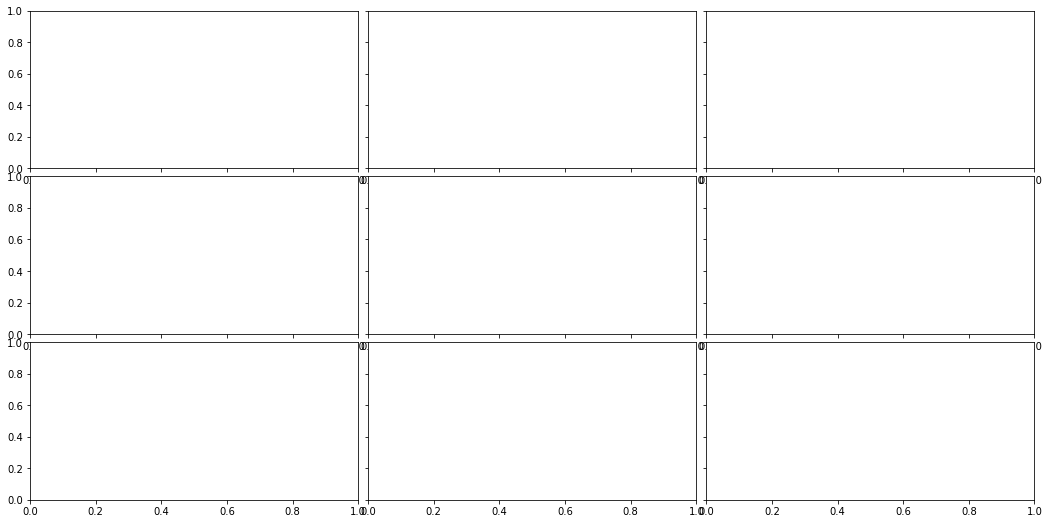

In [25]:
CONSTANT = 1
plt.rcParams['axes.titley'] = 1.05
beep = 0
print(beep)
beep+=1
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=True, figsize=(18, 9))
plt.subplots_adjust(wspace=0.03, hspace=0.05)
print(beep)
beep+=1
for i, d in enumerate(df_v['distribution'].unique()):
    # changed by dev-3 
    print("here")
    for j, b in enumerate([round(literal_eval(b)[1], 2) for b in df_v['simple_budgets'].unique()]):
        print(beep)
        beep+=1
        ax = axes[i, j]
        print(d)
        data = df_new[(df_new['budget'] == b) & (df_new['distribution'] == d) | (df_new['collector'] == 'GNMax')]
        print(data.shape)
        print("why not")
        sns.lineplot(data=data, x='labels', y='cost')#, hue='group'), #ci='sd', 
                     #palette=colors2,
                     #hue_order=colors2.keys(), alpha=0.8, ax=ax, legend=False, zorder=8)
print(beep)
beep+=1
labels = list(range(10))
avg_budgets = [[df_v.loc[(df_v['distribution'] == str({'all': (w1, w2)}))
                         & (df_v['budgets_linear'] == f'[{e1}, {e2}]')]['avg_budget'].iloc[0]
                for e1, e2 in [(CONSTANT * 1.0, CONSTANT * 2.0),
                               (CONSTANT * 1.0, CONSTANT * 4.0),
                               (CONSTANT * 1.0, CONSTANT * 8.0)]]
               for w1, w2 in [(0.75, 0.25), (0.5, 0.5), (0.25, 0.75)]]
kind = 'upsampling'
budgets = [round(literal_eval(b)[1], 2) for b in df_v['budgets'].unique()]
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        sns.lineplot(x=[0, 2000], y=[math.log(CONSTANT)] * 2, ax=ax, zorder=2, alpha=1, color='k', linestyle='-', lw=1)
        sns.lineplot(x=[0, 2000], y=[budgets[j]] * 2, ax=ax, zorder=2, alpha=1, color='k', linestyle='-', lw=1)
        sns.lineplot(x=[0, 2000], y=[avg_budgets[i][j]] * 2, ax=ax, zorder=2, alpha=1, color='k', linestyle='--', lw=1)
        ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
        ax.yaxis.set_major_locator(plt.MultipleLocator(1))
        ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
        ax.set_xlim(0, 2000)
        ax.set_ylim(0, 3.5)
        ax.grid(which='major', axis='x', color='lightgray', linewidth=1, zorder=1)
        ax.grid(which='minor', axis='x', color='lightgray', linewidth=1, linestyle='-', zorder=1)
        ax.grid(which='major', axis='y', color='lightgray', linewidth=1, zorder=1)
        ax.grid(which='minor', axis='y', color='lightgray', linewidth=1, linestyle='-', zorder=1)
        ax.set_ylabel(f'{25 if i == 0 else 50 if i == 1 else 75}% ratio',
                      fontsize=16)
        ax.set_xlabel('')


legend_elements = [Line2D([0], [0], linestyle='-', color='k', label='low/high budget', lw=2)] + \
[Line2D([0], [0], linestyle='--', color='k', label='average budget', lw=2)] + \
[Line2D([0], [0], color=colors2[kind], lw=2, label=kind) for kind in list(colors2.keys())]
axes[2, 0].legend(handles=legend_elements, loc='upper right', framealpha=1,
                  fontsize=12, bbox_to_anchor = [1, 1.25]).set_zorder(102)
for i in [0, 1]:
    for j in [0, 1, 2]:
        ax = axes[i, j]
        ax.set_xticks([500, 1000, 1500])
        ax.tick_params(axis='x', colors='white')
axes[2, 0].set_xticks([0, 500, 1000, 1500])
axes[2, 1].set_xticks([0, 500, 1000, 1500])
axes[2, 2].set_xticks([0, 500, 1000, 1500, 2000])
axes[0, 0].set_title(f'budgets:   log({CONSTANT}) | log({2 * CONSTANT})', fontsize=16)
axes[0, 1].set_title(f'budgets:   log({CONSTANT}) | log({4 * CONSTANT})', fontsize=16)
axes[0, 2].set_title(f'budgets:   log({CONSTANT}) | log({8 * CONSTANT})', fontsize=16)
fig.supylabel(r'DP costs in $\varepsilon$ for $\delta = 10^{-5}$', fontsize=20, x=0.065, y=0.5)
fig.supxlabel('# labels', fontsize=20, x=0.5, y=0.05)
plt.savefig(fname=f'cost_history_c{CONSTANT}_mnist.pdf', format='pdf')
plt.show()

...

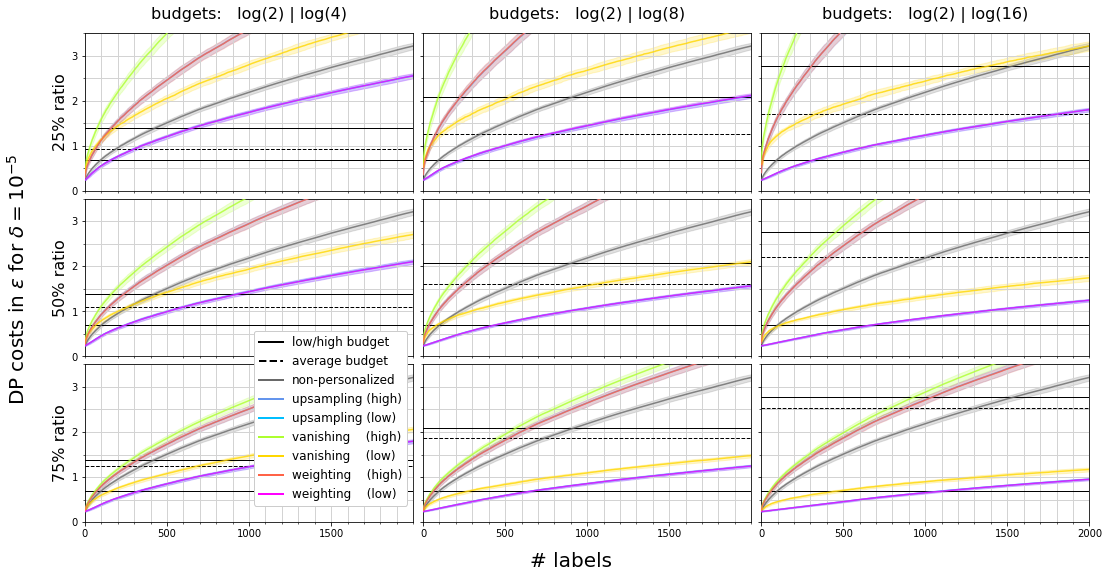

In [5]:
plt.rcParams['axes.titley'] = 1.05
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=True, figsize=(18, 9))
plt.subplots_adjust(wspace=0.03, hspace=0.05)

for i, d in enumerate(df_v['distribution'].unique()):
    for j, b in enumerate([round(literal_eval(b)[1], 2) for b in df_v['budgets'].unique()]):
        ax = axes[i, j]
        data = df_new[(df_new['budget'] == b) & (df_new['distribution'] == d) | (df_new['collector'] == 'GNMax')]
        sns.lineplot(data=data, x='labels', y='cost', hue='group', ci='sd', palette=colors2,
                     hue_order=colors2.keys(), alpha=0.8, ax=ax, legend=False, zorder=8)

labels = list(range(10))
avg_budgets = [[df_v.loc[(df_v['distribution'] == str({'all': (w1, w2)}))
                         & (df_v['budgets_linear'] == f'[{e1}, {e2}]')]['avg_budget'].iloc[0]
                for e1, e2 in [(CONSTANT * 1.0, CONSTANT * 2.0),
                               (CONSTANT * 1.0, CONSTANT * 4.0),
                               (CONSTANT * 1.0, CONSTANT * 8.0)]]
               for w1, w2 in [(0.75, 0.25), (0.5, 0.5), (0.25, 0.75)]]
kind = 'upsampling'
budgets = [round(literal_eval(b)[1], 2) for b in df_v['budgets'].unique()]
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        sns.lineplot(x=[0, 2000], y=[math.log(CONSTANT)] * 2, ax=ax, zorder=2, alpha=1, color='k', linestyle='-', lw=1)
        sns.lineplot(x=[0, 2000], y=[budgets[j]] * 2, ax=ax, zorder=2, alpha=1, color='k', linestyle='-', lw=1)
        sns.lineplot(x=[0, 2000], y=[avg_budgets[i][j]] * 2, ax=ax, zorder=2, alpha=1, color='k', linestyle='--', lw=1)
        ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
        ax.yaxis.set_major_locator(plt.MultipleLocator(1))
        ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
        ax.set_xlim(0, 2000)
        ax.set_ylim(0, 3.5)
        ax.grid(which='major', axis='x', color='lightgray', linewidth=1, zorder=1)
        ax.grid(which='minor', axis='x', color='lightgray', linewidth=1, linestyle='-', zorder=1)
        ax.grid(which='major', axis='y', color='lightgray', linewidth=1, zorder=1)
        ax.grid(which='minor', axis='y', color='lightgray', linewidth=1, linestyle='-', zorder=1)
        ax.set_ylabel(f'{25 if i == 0 else 50 if i == 1 else 75}% ratio',
                      fontsize=16)
        ax.set_xlabel('')


legend_elements = [Line2D([0], [0], linestyle='-', color='k', label='low/high budget', lw=2)] + \
[Line2D([0], [0], linestyle='--', color='k', label='average budget', lw=2)] + \
[Line2D([0], [0], color=colors2[kind], lw=2, label=kind) for kind in list(colors2.keys())]
axes[2, 0].legend(handles=legend_elements, loc='upper right', framealpha=1,
                  fontsize=12, bbox_to_anchor = [1, 1.25]).set_zorder(102)
for i in [0, 1]:
    for j in [0, 1, 2]:
        ax = axes[i, j]
        ax.set_xticks([500, 1000, 1500])
        ax.tick_params(axis='x', colors='white')
axes[2, 0].set_xticks([0, 500, 1000, 1500])
axes[2, 1].set_xticks([0, 500, 1000, 1500])
axes[2, 2].set_xticks([0, 500, 1000, 1500, 2000])
axes[0, 0].set_title(f'budgets:   log({CONSTANT}) | log({2 * CONSTANT})', fontsize=16)
axes[0, 1].set_title(f'budgets:   log({CONSTANT}) | log({4 * CONSTANT})', fontsize=16)
axes[0, 2].set_title(f'budgets:   log({CONSTANT}) | log({8 * CONSTANT})', fontsize=16)
fig.supylabel(r'DP costs in $\varepsilon$ for $\delta = 10^{-5}$', fontsize=20, x=0.065, y=0.5)
fig.supxlabel('# labels', fontsize=20, x=0.5, y=0.05)
plt.savefig(fname=f'cost_history_c{CONSTANT}_mnist.pdf', format='pdf')
plt.show()